# Анализ тональности

Будем проводить анализ тональности текста. Вся работа будет проводиться на данных <a href="https://ai.stanford.edu/~amaas/data/sentiment/">Large Movie Review Dataset v1.0</a>. Описание данных на английском языке:

*This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification.*

## Базовая модель

В этом параграфе будет осуществлён импорт данных и составлена первая базовая модель. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet("large_movie_review_dataset.parquet")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,positive
1,Homelessness (or Houselessness as George Carli...,positive
2,Brilliant over-acting by Lesley Ann Warren. Be...,positive
3,This is easily the most underrated film inn th...,positive
4,This is not the typical Mel Brooks film. It wa...,positive


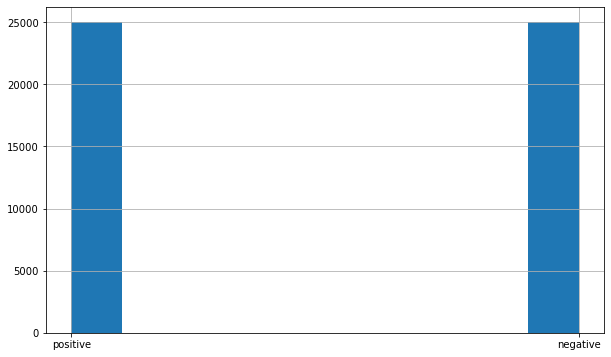

In [3]:
data["label"].hist(figsize=(10, 6))
plt.show()

Количество позитивных и негативных отзывов одинаковое. Общее количество объектов: $50\,000$. Задача: научиться определять тональность отзыва на имеющихся данных. 

Структура базовой модели: составляем словарь из всех слов в наборе данных. Допустим, таких слов $n$. Каждом слову сопоставляем вектор размерности $n$, в котором будет стоять единица на позиции, соответствующей позиции этого слова в словаре, и нули на всех остальных позициях. Каждому документу сопоставляем сумму векторного представления его слов. Получившиеся представления стандартизируем и строим модель логистической регрессии.

Разбиваем выборку на обучающую и тестовую

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
corpus = data["text"].apply(lambda t: t.lower()).values
y = data["label"].map({"negative": 0, "positive": 1}).values

In [6]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.25, random_state=42)

Посмотрим на количество положительных и отрицательных отзывов в обучающей выборке

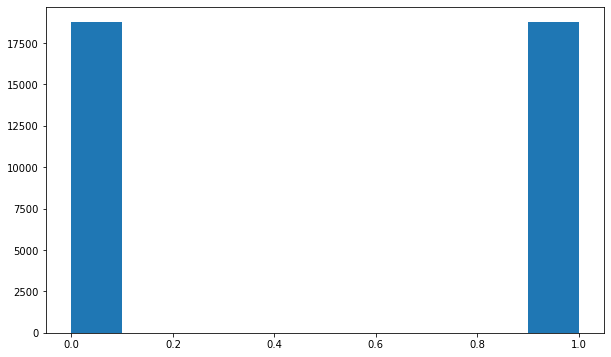

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(y_train)
plt.show()

Получилось примерно одинаково. Обучаем модель

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
model = Pipeline(
    [
        ("word_vectorizer", CountVectorizer()),
        ("scaler", StandardScaler(with_mean=False)),
        ("regression", LogisticRegression(solver="liblinear"))
    ]
)

In [10]:
%%time

model.fit(corpus_train, y_train)

Wall time: 14.6 s


Pipeline(steps=[('word_vectorizer', CountVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression', LogisticRegression(solver='liblinear'))])

Проверяем точность модели

In [11]:
y_pred = model.predict(corpus_test)

In [12]:
accuracy_score(y_test, y_pred)

0.85688

## TF-IDF 

Следующий шаг состоит в том, чтобы использовать `TF-IDF` для приведения текстовой информации к числовой. Мы так же попробуем отбросить стоп-слова. Попробуем несколько различных алгоритмов для финальной версии: логистическую регрессию, случайный лес, градиентный бустинг

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier

Вариант с логистической регрессией по `TF-IDF`

In [14]:
%%time

model_tfidf_logreg = Pipeline(
    [
        ("word_vectorizer", TfidfVectorizer(stop_words="english")),
        ("scaler", StandardScaler(with_mean=False)),
        ("regression", LogisticRegression(solver="liblinear"))
    ]
)

model_tfidf_logreg.fit(corpus_train, y_train)

Wall time: 9.78 s


Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('scaler', StandardScaler(with_mean=False)),
                ('regression', LogisticRegression(solver='liblinear'))])

In [15]:
y_pred = model_tfidf_logreg.predict(corpus_test)
accuracy_score(y_test, y_pred)

0.85504

Результат близок к предыдущему. Теперь попробуем случайный лес

In [16]:
%%time

model_tfidf_rf = Pipeline(
    [
        ("word_vectorizer", TfidfVectorizer(stop_words="english")),
        ("scaler", StandardScaler(with_mean=False)),
        ("random_forest", RandomForestClassifier(n_estimators=192, max_depth=17, max_features="log2", random_state=45))
    ]
)


model_tfidf_rf.fit(corpus_train, y_train)

Wall time: 8.45 s


Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('scaler', StandardScaler(with_mean=False)),
                ('random_forest',
                 RandomForestClassifier(max_depth=17, max_features='log2',
                                        n_estimators=192, random_state=45))])

In [17]:
y_pred = model_tfidf_rf.predict(corpus_test)
accuracy_score(y_test, y_pred)

0.80392

Результат хуже, чем у логистической регрессии. Перейдём к `xgboost`

In [18]:
%%time

model_tfidf_xgboost = Pipeline(
    [
        ("word_vectorizer", TfidfVectorizer(stop_words="english")),
        ("scaler", StandardScaler(with_mean=False)),
        ("random_forest", XGBClassifier(
            use_label_encoder=False, 
            n_estimators=75, 
            max_depth=25, 
            eval_metric="logloss", 
            random_state=45,
            learning_rate=0.5,
            verbosity=0
        ))
    ]
)


model_tfidf_xgboost.fit(corpus_train, y_train)

Wall time: 1min 33s


Pipeline(steps=[('word_vectorizer', TfidfVectorizer(stop_words='english')),
                ('scaler', StandardScaler(with_mean=False)),
                ('random_forest',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.5, max_delta_step=0,
                               max_depth=25, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=75,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=45, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                    

In [19]:
y_pred = model_tfidf_xgboost.predict(corpus_test)
accuracy_score(y_test, y_pred)

0.85608

Результат лучше, чем у случайного леса, но не лучше, чем у логистической регрессии. То есть, переход к `TF-IDF` ничего не дал. Перейдём к нейросетевым подходам

## Полносвязная нейросеть

Ещё один вариант: взять полносвязную нейросеть с несколькими нейронами и обучить её по выходу `CountVectorizer`. 

In [20]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [21]:
model_simple_nn = Sequential(name="model_simple_nn")
model_simple_nn.add(Dense(100, activation="sigmoid", name="first_layer"))
model_simple_nn.add(Dense(1, activation="sigmoid", name="output_layer"))
model_simple_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(corpus_train)
X_train.sort_indices()
X_train.shape

(37500, 90321)

In [23]:
model_simple_nn.fit(X_train, y_train.reshape(-1, 1), epochs=2)

Epoch 1/2
1172/1172 [==============================] - 51s 43ms/step - loss: 0.3032 - accuracy: 0.8784
Epoch 2/2
1172/1172 [==============================] - 51s 43ms/step - loss: 0.1380 - accuracy: 0.9508


Смотрим качество

In [24]:
X_test = vectorizer.transform(corpus_test)
X_test.sort_indices()
X_test.shape

(12500, 90321)

In [25]:
y_pred = model_simple_nn.predict(X_test)
accuracy_score(y_test, np.array(y_pred.flatten() > 0.5, dtype=np.int16))

0.89952

Использование нейросетей позволило поднять качество до 90%